In [11]:
from zones.raster_stats import _rasterize_zone
from zones import util

import geowombat as gw

from osgeo import ogr, osr
import geopandas as gpd
import rasterio as rio
from shapely.geometry import Polygon
from pyproj import CRS
from affine import Affine
import matplotlib.pyplot as plt

In [12]:
zones_df = gpd.read_file('vector/01_vector_wgs84.gpkg')

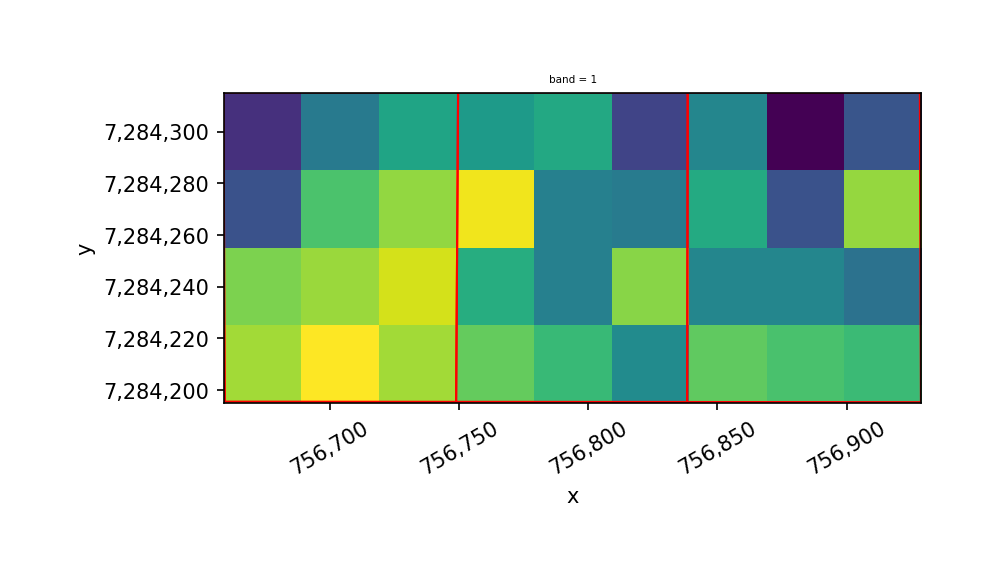

In [13]:
fig, ax = plt.subplots()

with gw.open('raster/01_single_band_utm.tif') as src:
    
#     zones_df = zones_df.to_crs(src.crs)
    
    src.sel(band=1).gw.imshow(add_colorbar=False, ax=ax)
    zones_df.to_crs(src.crs).plot(color='none', edgecolor='red', ax=ax)

In [25]:
osr.GetWellKnownGeogCSAsWKT('WGS84')

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'

In [31]:
src_wkt.replace('GEOGCRS["', 'GEOGCS["')

'GEOGCS["WGS 84",DATUM["World Geodetic System 1984",ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],CS[ellipsoidal,2],AXIS["geodetic latitude (Lat)",north,ORDER[1],ANGLEUNIT["degree",0.0174532925199433]],AXIS["geodetic longitude (Lon)",east,ORDER[2],ANGLEUNIT["degree",0.0174532925199433]],USAGE[SCOPE["Horizontal component of 3D system."],AREA["World."],BBOX[-90,-180,90,180]],ID["EPSG",4326]]'

In [36]:
with rio.open('raster/01_single_band_utm.tif') as image_src:

    src_wkt = zones_df.crs.to_wkt().replace('GEOGCRS["', 'GEOGCS["')
#     src_proj4 = zones_df.crs.to_proj4()
#     src_json = zones_df.crs.to_json()
    
    for didx, df_row in zones_df.to_crs(image_src.crs).iterrows():

        geom = df_row.geometry
    
        left, bottom, right, top = geom.bounds
    
        if (left < image_src.bounds.left) or \
                (bottom < image_src.bounds.bottom) or \
                (right > image_src.bounds.right) or \
                (top > image_src.bounds.top):

            raster_polygon = Polygon([(image_src.bounds.left, image_src.bounds.bottom),
                                      (image_src.bounds.left, image_src.bounds.top),
                                      (image_src.bounds.right, image_src.bounds.top),
                                      (image_src.bounds.right, image_src.bounds.bottom),
                                      (image_src.bounds.left, image_src.bounds.bottom)])            

            geom_df = gpd.GeoDataFrame(data=[0], geometry=[geom], crs=src_wkt)
            geom_df = gpd.clip(geom_df, raster_polygon)

            if geom_df.empty:
                print('WHAT?')
            
            geom_clip = gpd.clip(geom_df, raster_polygon)
            src_wkt = geom_clip.crs.to_wkt().replace('GEOGCRS["', 'GEOGCS["')
#             src_wkt = geom_crs.to_wkt()
#             src_proj4 = geom_crs.to_proj4()
#             src_json = geom_crs.to_json()
            
        # Create a memory layer to rasterize from.
        datasource = ogr.GetDriverByName('Memory').CreateDataSource('wrk')
        sp_ref = osr.SpatialReference()
        sp_ref.ImportFromWkt(src_wkt)
        util.check_axis_order(sp_ref)
        
#         # Transform the geometry
        target_sr = osr.SpatialReference()
        target_sr.ImportFromWkt(image_src.crs.to_wkt())
        util.check_axis_order(target_sr)
        transform = osr.CoordinateTransformation(sp_ref, target_sr)
        gdal_geom = ogr.CreateGeometryFromWkt(src_wkt)
        gdal_geom.Transform(transform)
        
        break

#         # Get the transformation boundary
#         left, right, bottom, top = gdal_geom.GetEnvelope()

        # Get the y and x count of the vector geometry
        xcount_vct = int(round((right - left) / abs(image_src.res[0])))
        ycount_vct = int(round((top - bottom) / abs(image_src.res[1])))

        # Get the minimum overlapping extent bounds
        #   between the raster and the vector geometry
        max_left = max(left, image_src.bounds.left)
        min_top = min(top, image_src.bounds.top)
        min_right = min(right, image_src.bounds.right)
        max_bottom = max(bottom, image_src.bounds.bottom)

        # Get the y and x count based on the minimum bounds
        xcount = int(round((min_right - max_left) / abs(image_src.res[0])))
        ycount = int(round((min_top - max_bottom) / abs(image_src.res[1])))        
        
        # Get the transform for the full vector extent
        vct_transform = Affine(abs(image_src.res[0]), 0.0, left, 0.0, -abs(image_src.res[1]), top)

        # Create the new layer
        lyr = datasource.CreateLayer('', geom_type=ogr.wkbPolygon, srs=target_sr)
        field_def = ogr.FieldDefn('Value', ogr.OFTInteger)
        lyr.CreateField(field_def)        
        
#         poly_array, image_array, left, top, right, bottom = _rasterize_zone(geom,
#                                                                             src_wkt,
#                                                                             image_src,
#                                                                             'raster/01_single_band_utm.tif',
#                                                                             None)
        
        break

AttributeError: 'NoneType' object has no attribute 'Transform'